# CS 485 CNN Development


---
# Mount


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
# Root

In [ ]:
root = '/content/drive/MyDrive/Colab_Notebooks/'

---
# Import libraries

In [ ]:
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import time
import random
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import torchvision.models as models
import torchvision
from torch.linalg import svd

In [ ]:
print(torch.__version__)
from torch import cuda
print(cuda.get_device_name(cuda.current_device()))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2.1.0+cu118
Tesla V100-SXM2-16GB


In [ ]:
#random.seed(52)

----
# Dataset Loading and Preprocessing

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        for class_folder in class_folders:
            class_path = os.path.join(self.root_dir, class_folder)
            image_files = os.listdir(class_path)
            random.seed(10)
            # Randomly select 30 images per class
            selected_files = random.sample(image_files, 30)
            self.images.extend([(os.path.join(class_path, file), class_folder) for file in selected_files])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path, class_name = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(class_to_idx[class_name])  # Convert class name to index
        return image, label

# Preprocessing Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize to a common size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Standard normalization for color images
])

# Creating Dataset
root_dir = '/content/drive/MyDrive/Colab_Notebooks/101_ObjectCategories'
class_folders = [folder for folder in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, folder))]
class_to_idx = {class_folders[i]: i for i in range(len(class_folders))}
idx_to_class = {idx: class_ for class_, idx in class_to_idx.items()}
#print(class_to_idx)
dataset = CustomDataset(root_dir, class_to_idx, transform=transform)

# Splitting the Dataset into Train and Test
train_size = 15 * len(class_folders)
test_size = len(dataset) - train_size
dataset_train, dataset_test = torch.utils.data.random_split(dataset, [train_size, test_size])

# Data Loaders
train_loader = DataLoader(dataset_train, batch_size=10, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=10, shuffle=False)

In [ ]:
print(len(train_loader))

15


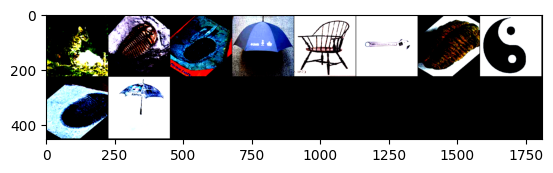

In [ ]:
# Function to visualize a batch of images
def imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.show()

# Visualize a Batch of Images
dataiter = iter(train_loader)
images, labels = next(dataiter)  # get one batch of training images

# Show images
imshow(torchvision.utils.make_grid(images))

#print(' '.join('%5s' % labels[j] for j in range(len(labels))))

In [ ]:
print()
print("Image Shape: {}".format(dataset_train[0][0].shape))
print()
print("Training Set:   {} samples".format(len(dataset_train)))
print("Test Set:       {} samples".format(len(dataset_test)))


Image Shape: torch.Size([3, 224, 224])

Training Set:   150 samples
Test Set:       150 samples


tick


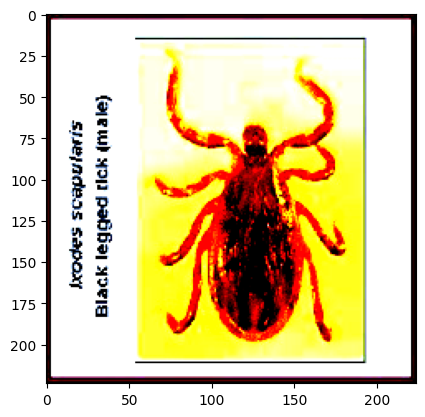

In [ ]:
import pdb
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(dataset_train))
image = dataset_train[index][0].squeeze()

plt.imshow(np.transpose(image, (1, 2, 0)))
print(idx_to_class[dataset_train[index][1].item()])

In [ ]:
# Get one batch of data
images, labels = next(iter(train_loader))

# Check types
print(f"Type of images: {type(images)}")
print(f"Type of labels: {type(labels)}")



Type of images: <class 'torch.Tensor'>
Type of labels: <class 'torch.Tensor'>


---
# Model Parameter Calculation

In [ ]:
def print_model_parameters(model):
    """
    Function to print the parameter count layer by layer and the total parameter count
    for a PyTorch model.

    Args:
    model (torch.nn.Module): The PyTorch model whose parameters need to be counted.

    Returns:
    None, but prints the parameter count for each layer and the total parameter count.
    """
    total_params = 0
    print("Parameter count for each layer:")
    for name, parameter in model.named_parameters():
        if parameter.requires_grad:
            param_count = parameter.numel()
            total_params += param_count
            print(f"{name}: {param_count}")
    print(f"Total trainable parameters in the model: {total_params}")

---
# Square Hinge_loss

In [ ]:
def squared_hinge_loss(input, target):
    """
    Squared hinge loss for multi-class classification.

    Args:
    - input (Tensor): Predicted values (logits), of shape (N, C) where C is the number of classes.
    - target (Tensor): True class labels, of shape (N,), with integer values in [0, C-1].

    Returns:
    - Tensor: The loss.
    """
    num_classes = input.size(1)
    correct_scores = input[torch.arange(input.size(0)), target].unsqueeze(1)
    margins = torch.clamp(1 + input - correct_scores, min=0)
    margins[torch.arange(input.size(0)), target] = 0
    loss = torch.mean(torch.sum(margins ** 2, dim=1))
    return loss

# Train and Evaluation Functions

In [ ]:
def train(epoch, model, criterion, optimizer, train_loader = train_loader):
    global cur_batch_win
    model.train()
    loss_list, batch_list = [], []
    epoch_loss = 0.0
    model.to(device)
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)

        loss_list.append(loss.detach().cpu().item())
        epoch_loss += loss.detach().cpu().item()
        batch_list.append(i+1)

        #if i % 15 == 0:
            #print('Train - Epoch %d, Batch: %d, Loss: %f' % (epoch, i, loss.detach().cpu().item()))

        loss.backward()
        optimizer.step()
    epoch_loss /= len(train_loader)
    return epoch_loss

In [ ]:
def evaluate(model, target_loader, target_dataset, criterion):
    predictions = []
    model.eval()
    total_correct = 0
    avg_loss = 0.0
    model.to(device)

    with torch.no_grad():
        for images, labels in target_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            avg_loss += loss.item()

            pred = output.argmax(dim=1)
            total_correct += pred.eq(labels).sum().item()
            predictions.append(pred.cpu())

    avg_loss /= len(target_loader)
    accuracy = float(total_correct) / len(target_dataset)

    return accuracy, np.array(torch.cat(predictions).cpu())

In [ ]:
class ModelData:
    def __init__(self):
        self.train_accuracy = []
        self.test_accuracy = []
        self.loss = []

def run(model, epochs, criterion, optimizer, reinitialize=False, train_loader = train_loader, test_loader = test_loader):
    if reinitialize:
        model.apply(weight_reset)  # Custom function to reinitialize weights
        optimizer = type(optimizer)(model.parameters(), **optimizer.defaults)  # Reinitialize optimizer


    data = ModelData()

    model_name = type(model).__name__

    filename = f'{model_name}_saved.model'


    print("Training...")
    print()
    for e in range(1, epochs):
        #print(train_loader.batch_size)
        loss = train(e, model, criterion, optimizer, train_loader)
        train_accuracy, train_predictions = evaluate(model, train_loader, dataset_train, criterion)
        test_accuracy, test_predictions = evaluate(model, test_loader, dataset_test, criterion)
        data.loss.append(loss)
        data.train_accuracy.append(train_accuracy)
        data.test_accuracy.append(test_accuracy)
        print("EPOCH {} ...".format(e))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print("Test Accuracy = {:.3f}".format(test_accuracy))
        print()

    torch.save(
        {
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
        },
        filename
    )
    print(f"Model saved as {filename}")

    return data

def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

# Models

In [ ]:
class SimpleCNN_BN(nn.Module):
    def __init__(self, dropout = True):
        super(SimpleCNN_BN, self).__init__()
        self.dropout = dropout

        # Define convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False)

        # Define batch normalization layers
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(256)

        # Define fully connected layers
        self.fc1 = nn.Linear(256 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Conv -> ReLU -> MaxPool -> BatchNorm
        x = F.relu(self.conv1(x))
        x = self.bn1(F.max_pool2d(x, 2))

        x = F.relu(self.conv2(x))
        x = self.bn2(F.max_pool2d(x, 2))

        x = F.relu(self.conv3(x))
        x = self.bn3(F.max_pool2d(x, 2))

        x = F.relu(self.conv4(x))
        x = self.bn4(F.max_pool2d(x, 2))

        x = F.relu(self.conv5(x))
        x = self.bn5(F.max_pool2d(x, 2))

        x = x.view(x.size(0), -1)  # Flatten the tensor
        #print(x.size())

        # Fully connected layers
        x = F.relu(self.fc1(x))
        if self.dropout:
          x = F.dropout(x, 0.5, training=self.training)
        x = self.fc2(x)

        return x

In [ ]:
class SimpleCNN_GN(nn.Module):
    def __init__(self, dropout = True):
        super(SimpleCNN_GN, self).__init__()
        self.dropout = dropout

        # Define convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False)

        # Define group normalization layers
        # Adjust num_groups as needed
        self.gn1 = nn.GroupNorm(num_groups=4, num_channels=16)
        self.gn2 = nn.GroupNorm(num_groups=8, num_channels=32)
        self.gn3 = nn.GroupNorm(num_groups=16, num_channels=64)
        self.gn4 = nn.GroupNorm(num_groups=32, num_channels=128)
        self.gn5 = nn.GroupNorm(num_groups=64, num_channels=256)

        # Define fully connected layers
        self.fc1 = nn.Linear(256 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Conv -> ReLU -> MaxPool -> GroupNorm
        x = F.relu(self.conv1(x))
        x = self.gn1(F.max_pool2d(x, 2))

        x = F.relu(self.conv2(x))
        x = self.gn2(F.max_pool2d(x, 2))

        x = F.relu(self.conv3(x))
        x = self.gn3(F.max_pool2d(x, 2))

        x = F.relu(self.conv4(x))
        x = self.gn4(F.max_pool2d(x, 2))

        x = F.relu(self.conv5(x))
        x = self.gn5(F.max_pool2d(x, 2))

        x = x.view(x.size(0), -1)  # Flatten the tensor

        # Fully connected layers
        x = F.relu(self.fc1(x))
        if self.dropout:
          x = F.dropout(x, 0.5, training=self.training)
        x = self.fc2(x)

        return x


In [ ]:
class SimpleCNN_2_BN(nn.Module):
    def __init__(self, dropout = True):
        super(SimpleCNN_2_BN, self).__init__()
        self.dropout = dropout

        # Define convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False)
        self.conv5 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)

        # Define batch normalization layers
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(3136, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Conv -> ReLU -> MaxPool -> BatchNorm
        x = F.relu(self.conv1(x))
        x = self.bn1(F.max_pool2d(x, 2))

        x = F.relu(self.conv2(x))
        x = self.bn2(F.max_pool2d(x, 2))

        x = F.relu(self.conv5(x))
        x = self.bn5(F.max_pool2d(x, 2))

        # Additional Max Pooling Layers
        x = F.max_pool2d(x, 2)
        x = F.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)  # Flatten the tensor
        #print(x.size())

        # Fully connected layers
        x = F.relu(self.fc1(x))
        if self.dropout:
          x = F.dropout(x, 0.5, training=self.training)
        x = self.fc2(x)

        return x


In [ ]:
class SimpleCNN_2_GN(nn.Module):
    def __init__(self, dropout = True):
        super(SimpleCNN_2_GN, self).__init__()

        self.dropout = dropout

        # Define convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False)
        self.conv5 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)

        # Define group normalization layers
        self.gn1 = nn.GroupNorm(4, 16)  # Assuming 4 groups for 16 channels
        self.gn2 = nn.GroupNorm(8, 32)  # Assuming 8 groups for 32 channels
        self.gn5 = nn.GroupNorm(16, 64) # Assuming 16 groups for 64 channels

        self.fc1 = nn.Linear(3136, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Conv -> ReLU -> MaxPool -> GroupNorm
        x = F.relu(self.conv1(x))
        x = self.gn1(F.max_pool2d(x, 2))

        x = F.relu(self.conv2(x))
        x = self.gn2(F.max_pool2d(x, 2))

        x = F.relu(self.conv5(x))
        x = self.gn5(F.max_pool2d(x, 2))

        # Additional Max Pooling Layers
        x = F.max_pool2d(x, 2)
        x = F.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)  # Flatten the tensor

        # Fully connected layers
        x = F.relu(self.fc1(x))
        if self.dropout:
          x = F.dropout(x, 0.5, training=self.training)
        x = self.fc2(x)

        return x


In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)

        # Max-pooling layers
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(6400, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

    def forward(self, x):
        # Convolutional layers with ReLU activations and max-pooling
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        #print(x.size())

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        #print(x.size())

        # Fully connected layers with ReLU activations and dropout
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5, training=self.training)
        x = self.fc3(x)

        return x


# Train Test Models

In [ ]:
net1 = SimpleCNN_BN()
#print(net)
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net1.parameters(), lr=learning_rate)
model1 = run(net1, 15, criterion, optimizer)
#print(model1.train_accuracy)
#print(model1.test_accuracy)
#print(model1.loss)


Training...



KeyboardInterrupt: ignored

In [ ]:
net2 = SimpleCNN_2_BN()
#print(net)
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net2.parameters(), lr=learning_rate)
model2 = run(net2, 15, criterion, optimizer)

Training...

EPOCH 1 ...
Train Accuracy = 0.653
Test Accuracy = 0.413

EPOCH 2 ...
Train Accuracy = 0.833
Test Accuracy = 0.467

EPOCH 3 ...
Train Accuracy = 0.900
Test Accuracy = 0.507

EPOCH 4 ...
Train Accuracy = 0.953
Test Accuracy = 0.547

EPOCH 5 ...
Train Accuracy = 0.967
Test Accuracy = 0.567

EPOCH 6 ...
Train Accuracy = 0.980
Test Accuracy = 0.633

EPOCH 7 ...
Train Accuracy = 0.993
Test Accuracy = 0.580

EPOCH 8 ...
Train Accuracy = 1.000
Test Accuracy = 0.607

EPOCH 9 ...
Train Accuracy = 0.993
Test Accuracy = 0.567

EPOCH 10 ...
Train Accuracy = 0.993
Test Accuracy = 0.560

EPOCH 11 ...
Train Accuracy = 1.000
Test Accuracy = 0.613

EPOCH 12 ...
Train Accuracy = 0.980
Test Accuracy = 0.580

EPOCH 13 ...
Train Accuracy = 0.993
Test Accuracy = 0.607

EPOCH 14 ...
Train Accuracy = 1.000
Test Accuracy = 0.567

Model saved as SimpleCNN_2_BN_saved.model


In [ ]:
net3 = AlexNet()
#print(net)
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net3.parameters(), lr=learning_rate)
model3 = run(net3, 30, criterion, optimizer)

Training...

EPOCH 1 ...
Train Accuracy = 0.107
Test Accuracy = 0.093

EPOCH 2 ...
Train Accuracy = 0.120
Test Accuracy = 0.080

EPOCH 3 ...
Train Accuracy = 0.120
Test Accuracy = 0.067

EPOCH 4 ...
Train Accuracy = 0.167
Test Accuracy = 0.133

EPOCH 5 ...
Train Accuracy = 0.220
Test Accuracy = 0.160

EPOCH 6 ...
Train Accuracy = 0.287
Test Accuracy = 0.213

EPOCH 7 ...
Train Accuracy = 0.360
Test Accuracy = 0.287

EPOCH 8 ...
Train Accuracy = 0.327
Test Accuracy = 0.247

EPOCH 9 ...
Train Accuracy = 0.513
Test Accuracy = 0.360

EPOCH 10 ...
Train Accuracy = 0.580
Test Accuracy = 0.347

EPOCH 11 ...
Train Accuracy = 0.533
Test Accuracy = 0.387

EPOCH 12 ...
Train Accuracy = 0.653
Test Accuracy = 0.440

EPOCH 13 ...
Train Accuracy = 0.733
Test Accuracy = 0.427

EPOCH 14 ...
Train Accuracy = 0.713
Test Accuracy = 0.413

EPOCH 15 ...
Train Accuracy = 0.800
Test Accuracy = 0.447

EPOCH 16 ...
Train Accuracy = 0.773
Test Accuracy = 0.447

EPOCH 17 ...
Train Accuracy = 0.767
Test Accuracy = 

In [ ]:
print_model_parameters(net1)
print_model_parameters(net2)
print_model_parameters(net3)

Parameter count for each layer:
conv1.weight: 432
conv2.weight: 4608
conv3.weight: 18432
conv4.weight: 73728
conv5.weight: 294912
bn1.weight: 16
bn1.bias: 16
bn2.weight: 32
bn2.bias: 32
bn3.weight: 64
bn3.bias: 64
bn4.weight: 128
bn4.bias: 128
bn5.weight: 256
bn5.bias: 256
fc1.weight: 1605632
fc1.bias: 128
fc2.weight: 1280
fc2.bias: 10
Total trainable parameters in the model: 2000154
Parameter count for each layer:
conv1.weight: 432
conv2.weight: 4608
conv5.weight: 18432
bn1.weight: 16
bn1.bias: 16
bn2.weight: 32
bn2.bias: 32
bn5.weight: 64
bn5.bias: 64
fc1.weight: 401408
fc1.bias: 128
fc2.weight: 1280
fc2.bias: 10
Total trainable parameters in the model: 426522
Parameter count for each layer:
conv1.weight: 34848
conv1.bias: 96
conv2.weight: 614400
conv2.bias: 256
conv3.weight: 884736
conv3.bias: 384
conv4.weight: 1327104
conv4.bias: 384
conv5.weight: 884736
conv5.bias: 256
fc1.weight: 26214400
fc1.bias: 4096
fc2.weight: 16777216
fc2.bias: 4096
fc3.weight: 40960
fc3.bias: 10
Total trai

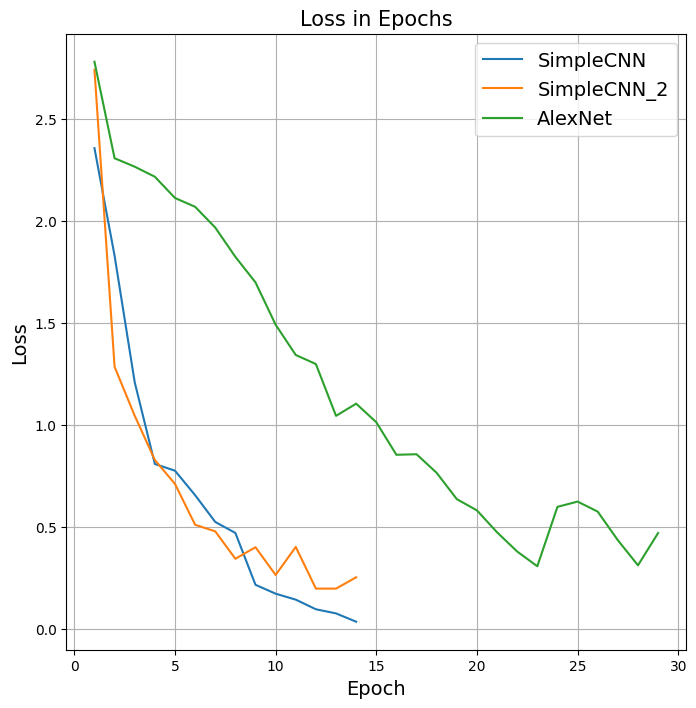

In [ ]:
#Loss Plot
plt.figure(figsize=(8, 8))
plt.plot(range(1, 15), model1.loss, label=f'SimpleCNN')
plt.plot(range(1, 15), model2.loss, label=f'SimpleCNN_2')
plt.plot(range(1, 30), model3.loss, label=f'AlexNet')
plt.title("Loss in Epochs", fontsize = 15)
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid(True)
plt.show()


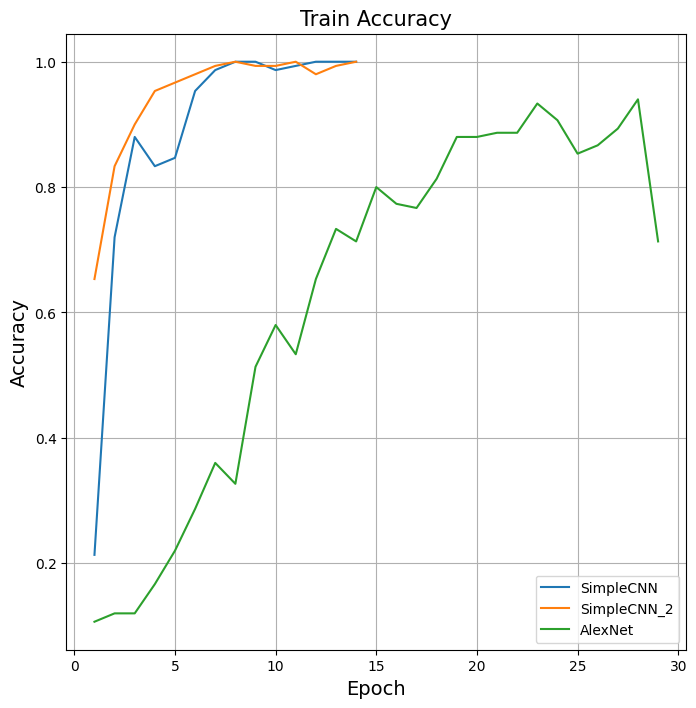

In [ ]:
#train accuracy Plot
plt.figure(figsize=(8, 8))
plt.plot(range(1, 15), model1.train_accuracy, label=f'SimpleCNN')
plt.plot(range(1, 15), model2.train_accuracy, label=f'SimpleCNN_2')
plt.plot(range(1, 30), model3.train_accuracy, label=f'AlexNet')
plt.title("Train Accuracy", fontsize = 15)
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.legend()
plt.grid(True)
plt.show()

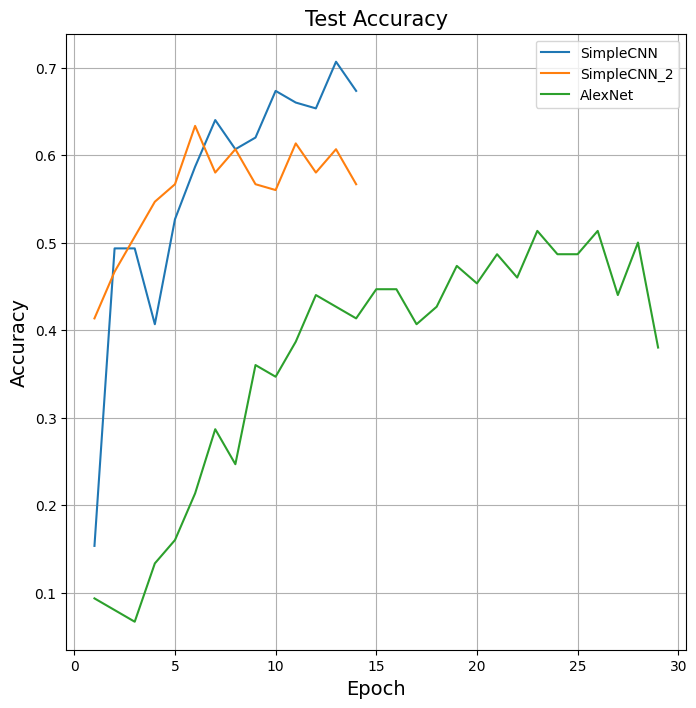

In [ ]:
#train accuracy Plot
plt.figure(figsize=(8, 8))
plt.plot(range(1, 15), model1.test_accuracy, label=f'SimpleCNN')
plt.plot(range(1, 15), model2.test_accuracy, label=f'SimpleCNN_2')
plt.plot(range(1, 30), model3.test_accuracy, label=f'AlexNet')
plt.title("Test Accuracy", fontsize = 15)
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.legend()
plt.grid(True)
plt.show()

#Batch Normalization Test

In [ ]:
net1_2 = SimpleCNN_GN()
net2_2 = SimpleCNN_2_GN()
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer_1 = optim.Adam(net1_2.parameters(), lr=learning_rate)
optimizer_2 = optim.Adam(net2_2.parameters(), lr=learning_rate)
model1_gn = run(net1_2, 15, criterion, optimizer_1)
model2_gn = run(net2_2, 15, criterion, optimizer_2)

Training...

EPOCH 1 ...
Train Accuracy = 0.707
Test Accuracy = 0.433

EPOCH 2 ...
Train Accuracy = 0.860
Test Accuracy = 0.513

EPOCH 3 ...
Train Accuracy = 0.947
Test Accuracy = 0.593

EPOCH 4 ...
Train Accuracy = 0.993
Test Accuracy = 0.600

EPOCH 5 ...
Train Accuracy = 0.980
Test Accuracy = 0.553

EPOCH 6 ...
Train Accuracy = 0.993
Test Accuracy = 0.547

EPOCH 7 ...
Train Accuracy = 0.993
Test Accuracy = 0.580

EPOCH 8 ...
Train Accuracy = 0.993
Test Accuracy = 0.613

EPOCH 9 ...
Train Accuracy = 1.000
Test Accuracy = 0.587

EPOCH 10 ...
Train Accuracy = 1.000
Test Accuracy = 0.640

EPOCH 11 ...
Train Accuracy = 1.000
Test Accuracy = 0.573

EPOCH 12 ...
Train Accuracy = 1.000
Test Accuracy = 0.567

EPOCH 13 ...
Train Accuracy = 1.000
Test Accuracy = 0.587

EPOCH 14 ...
Train Accuracy = 1.000
Test Accuracy = 0.607

Model saved as SimpleCNN_GN_saved.model
Training...

EPOCH 1 ...
Train Accuracy = 0.627
Test Accuracy = 0.427

EPOCH 2 ...
Train Accuracy = 0.687
Test Accuracy = 0.500

E

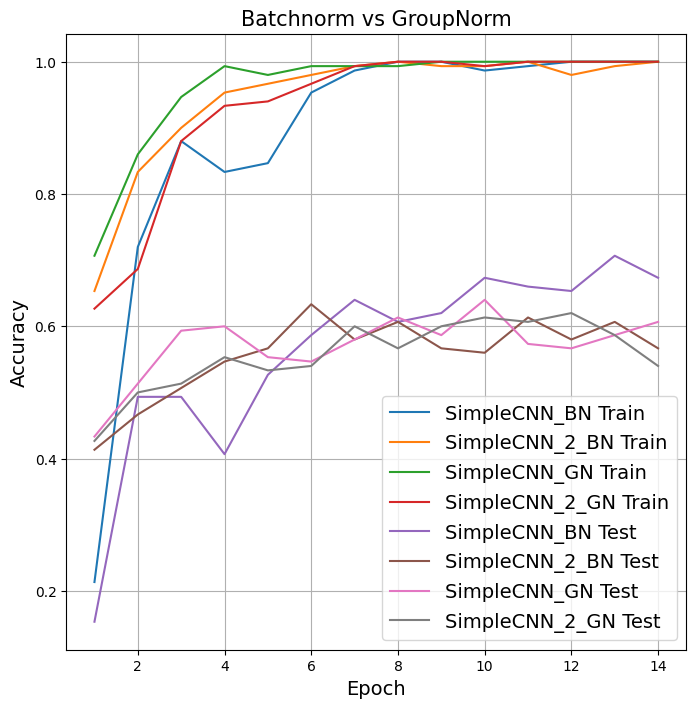

In [ ]:
#plot train, test accuracy for batchnorm and groupnorm
#train accuracy Plot
plt.figure(figsize=(8, 8))
plt.plot(range(1, 15), model1.train_accuracy, label=f'SimpleCNN_BN Train')
plt.plot(range(1, 15), model2.train_accuracy, label=f'SimpleCNN_2_BN Train')
plt.plot(range(1, 15), model1_gn.train_accuracy, label=f'SimpleCNN_GN Train')
plt.plot(range(1, 15), model2_gn.train_accuracy, label=f'SimpleCNN_2_GN Train')



plt.plot(range(1, 15), model1.test_accuracy, label=f'SimpleCNN_BN Test')
plt.plot(range(1, 15), model2.test_accuracy, label=f'SimpleCNN_2_BN Test')
plt.plot(range(1, 15), model1_gn.test_accuracy, label=f'SimpleCNN_GN Test')
plt.plot(range(1, 15), model2_gn.test_accuracy, label=f'SimpleCNN_2_GN Test')
plt.title("Batchnorm vs GroupNorm", fontsize = 15)
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid(True)
plt.show()

#Dropout Test

In [ ]:
#Dropout = False
net1_1_F = SimpleCNN_BN(dropout=False)
net1_2_F = SimpleCNN_2_BN(dropout=False)
net2_1_F = SimpleCNN_GN(dropout=False)
net2_2_F = SimpleCNN_2_GN(dropout=False)
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer_1 = optim.Adam(net1_1_F.parameters(), lr=learning_rate)
optimizer_2 = optim.Adam(net1_2_F.parameters(), lr=learning_rate)
optimizer_1 = optim.Adam(net2_1_F.parameters(), lr=learning_rate)
optimizer_2 = optim.Adam(net2_2_F.parameters(), lr=learning_rate)
model1_1_F = run(net1_1_F, 15, criterion, optimizer_1, True)
model1_2_F = run(net1_2_F, 15, criterion, optimizer_2, True)
model2_1_F = run(net2_1_F, 15, criterion, optimizer_1, True)
model2_2_F = run(net2_2_F, 15, criterion, optimizer_2, True)


Training...

EPOCH 1 ...
Train Accuracy = 0.480
Test Accuracy = 0.340

EPOCH 2 ...
Train Accuracy = 0.760
Test Accuracy = 0.480

EPOCH 3 ...
Train Accuracy = 0.860
Test Accuracy = 0.520

EPOCH 4 ...
Train Accuracy = 0.967
Test Accuracy = 0.560

EPOCH 5 ...
Train Accuracy = 0.980
Test Accuracy = 0.553

EPOCH 6 ...
Train Accuracy = 0.987
Test Accuracy = 0.553

EPOCH 7 ...
Train Accuracy = 1.000
Test Accuracy = 0.613

EPOCH 8 ...
Train Accuracy = 1.000
Test Accuracy = 0.607

EPOCH 9 ...
Train Accuracy = 1.000
Test Accuracy = 0.627

EPOCH 10 ...
Train Accuracy = 1.000
Test Accuracy = 0.600

EPOCH 11 ...
Train Accuracy = 1.000
Test Accuracy = 0.607

EPOCH 12 ...
Train Accuracy = 1.000
Test Accuracy = 0.600

EPOCH 13 ...
Train Accuracy = 1.000
Test Accuracy = 0.627

EPOCH 14 ...
Train Accuracy = 1.000
Test Accuracy = 0.627

Model saved as SimpleCNN_BN_saved.model
Training...

EPOCH 1 ...
Train Accuracy = 0.560
Test Accuracy = 0.347

EPOCH 2 ...
Train Accuracy = 0.813
Test Accuracy = 0.473

E

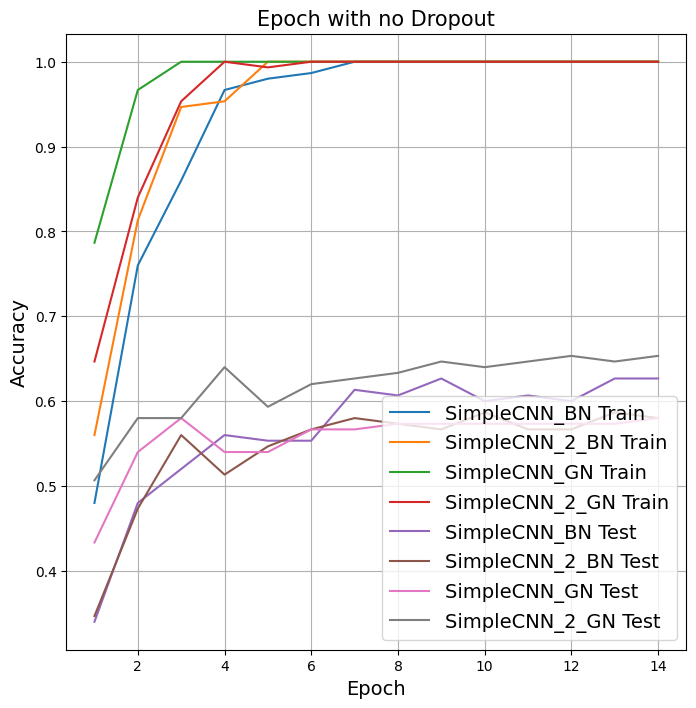

In [ ]:
#plot train, test accuracy for batchnorm and groupnorm
#train accuracy Plot
plt.figure(figsize=(8, 8))
plt.plot(range(1, 15), model1_1_F.train_accuracy, label=f'SimpleCNN_BN Train')
plt.plot(range(1, 15), model1_2_F.train_accuracy, label=f'SimpleCNN_2_BN Train')
plt.plot(range(1, 15), model2_1_F.train_accuracy, label=f'SimpleCNN_GN Train')
plt.plot(range(1, 15), model2_2_F.train_accuracy, label=f'SimpleCNN_2_GN Train')



plt.plot(range(1, 15), model1_1_F.test_accuracy, label=f'SimpleCNN_BN Test')
plt.plot(range(1, 15), model1_2_F.test_accuracy, label=f'SimpleCNN_2_BN Test')
plt.plot(range(1, 15), model2_1_F.test_accuracy, label=f'SimpleCNN_GN Test')
plt.plot(range(1, 15), model2_2_F.test_accuracy, label=f'SimpleCNN_2_GN Test')
plt.title("Epoch with no Dropout", fontsize = 15)
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid(True)
plt.show()

#Loss Function Test

In [ ]:
#loss function test softmax vs squared hinge loss
#we choose simpleCNN_2 with batchnorm, dropout = True
net_softmax = SimpleCNN_BN()
net_sqhl = SimpleCNN_BN()
learning_rate = 0.001
softmax = nn.CrossEntropyLoss()
optimizer_1 = optim.Adam(net_softmax.parameters(), lr=learning_rate)
optimizer_2 = optim.Adam(net_sqhl.parameters(), lr=learning_rate)
softmax_model = run(net_softmax, 15, softmax, optimizer_1, True)
sqhl_model = run(net_sqhl, 15, squared_hinge_loss, optimizer_2, True)

Training...

EPOCH 1 ...
Train Accuracy = 0.407
Test Accuracy = 0.300

EPOCH 2 ...
Train Accuracy = 0.793
Test Accuracy = 0.487

EPOCH 3 ...
Train Accuracy = 0.893
Test Accuracy = 0.540

EPOCH 4 ...
Train Accuracy = 0.900
Test Accuracy = 0.520

EPOCH 5 ...
Train Accuracy = 0.967
Test Accuracy = 0.567

EPOCH 6 ...
Train Accuracy = 0.880
Test Accuracy = 0.507

EPOCH 7 ...
Train Accuracy = 0.960
Test Accuracy = 0.573

EPOCH 8 ...
Train Accuracy = 0.960
Test Accuracy = 0.573

EPOCH 9 ...
Train Accuracy = 0.987
Test Accuracy = 0.600

EPOCH 10 ...
Train Accuracy = 0.993
Test Accuracy = 0.600

EPOCH 11 ...
Train Accuracy = 1.000
Test Accuracy = 0.613

EPOCH 12 ...
Train Accuracy = 0.993
Test Accuracy = 0.600

EPOCH 13 ...
Train Accuracy = 0.993
Test Accuracy = 0.580

EPOCH 14 ...
Train Accuracy = 0.993
Test Accuracy = 0.640

Model saved as SimpleCNN_BN_saved.model
Training...

EPOCH 1 ...
Train Accuracy = 0.173
Test Accuracy = 0.107

EPOCH 2 ...
Train Accuracy = 0.587
Test Accuracy = 0.340

E

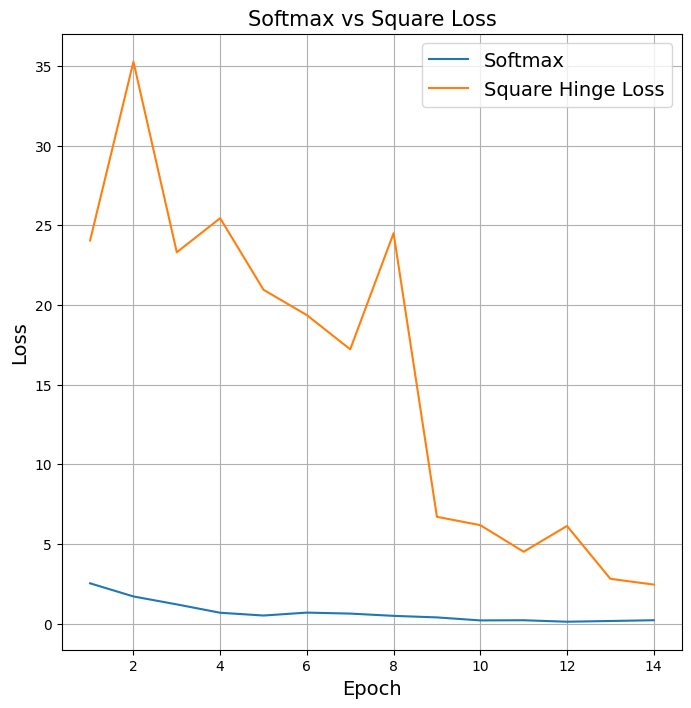

In [ ]:
#plot loss for softmax vs square loss
plt.figure(figsize=(8, 8))
plt.plot(range(1, 15), softmax_model.loss, label=f'Softmax')
plt.plot(range(1, 15), sqhl_model.loss, label=f'Square Hinge Loss')

plt.title("Softmax vs Square Loss", fontsize = 15)
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid(True)
plt.show()

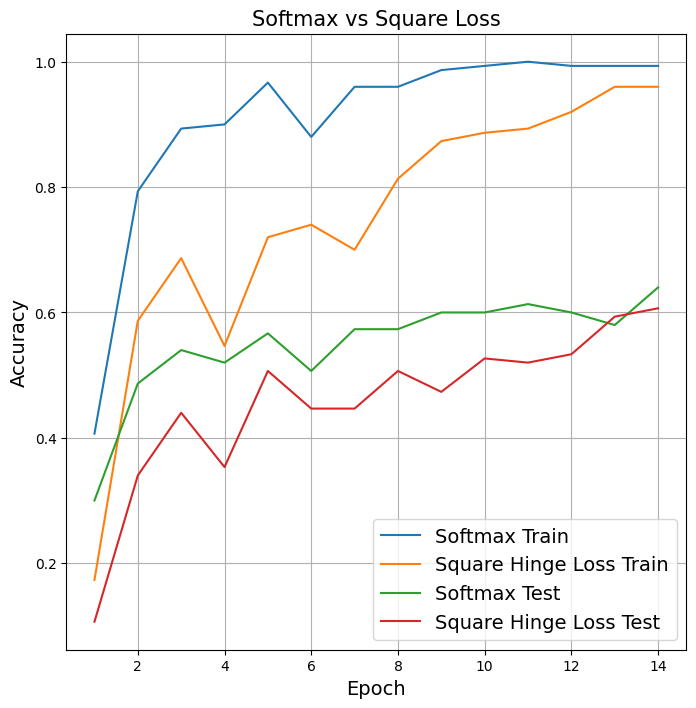

In [ ]:
#plot train, test accuracy for softmax vs square loss
plt.figure(figsize=(8, 8))
plt.plot(range(1, 15), softmax_model.train_accuracy, label=f'Softmax Train')
plt.plot(range(1, 15), sqhl_model.train_accuracy, label=f'Square Hinge Loss Train')

plt.plot(range(1, 15), softmax_model.test_accuracy, label=f'Softmax Test')
plt.plot(range(1, 15), sqhl_model.test_accuracy, label=f'Square Hinge Loss Test')

plt.title("Softmax vs Square Loss", fontsize = 15)
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid(True)
plt.show()

#Learning Rate Test

In [ ]:
#Learning rate test
lrnet1 = SimpleCNN_BN()
lrnet2 = SimpleCNN_BN()
lrnet3 = SimpleCNN_BN()
lrnet4 = SimpleCNN_BN()
learning_rates = [0.1, 0.01, 0.001, 0.0001]
criterion = nn.CrossEntropyLoss()
optimizer_1 = optim.Adam(lrnet1.parameters(), lr=learning_rates[0])
optimizer_2 = optim.Adam(lrnet2.parameters(), lr=learning_rates[1])
optimizer_3 = optim.Adam(lrnet3.parameters(), lr=learning_rates[2])
optimizer_4 = optim.Adam(lrnet4.parameters(), lr=learning_rates[3])
lrmodel1 = run(lrnet1, 15, criterion, optimizer_1, True)
lrmodel2 = run(lrnet2, 15, criterion, optimizer_2, True)
lrmodel3 = run(lrnet3, 15, criterion, optimizer_3, True)
lrmodel4 = run(lrnet4, 15, criterion, optimizer_4, True)


Training...

EPOCH 1 ...
Train Accuracy = 0.100
Test Accuracy = 0.133

EPOCH 2 ...
Train Accuracy = 0.127
Test Accuracy = 0.073

EPOCH 3 ...
Train Accuracy = 0.113
Test Accuracy = 0.060

EPOCH 4 ...
Train Accuracy = 0.120
Test Accuracy = 0.080

EPOCH 5 ...
Train Accuracy = 0.120
Test Accuracy = 0.080

EPOCH 6 ...
Train Accuracy = 0.120
Test Accuracy = 0.080

EPOCH 7 ...
Train Accuracy = 0.120
Test Accuracy = 0.080

EPOCH 8 ...
Train Accuracy = 0.120
Test Accuracy = 0.080

EPOCH 9 ...
Train Accuracy = 0.120
Test Accuracy = 0.080

EPOCH 10 ...
Train Accuracy = 0.120
Test Accuracy = 0.087

EPOCH 11 ...
Train Accuracy = 0.120
Test Accuracy = 0.080

EPOCH 12 ...
Train Accuracy = 0.120
Test Accuracy = 0.080

EPOCH 13 ...
Train Accuracy = 0.120
Test Accuracy = 0.080

EPOCH 14 ...
Train Accuracy = 0.120
Test Accuracy = 0.080

Model saved as SimpleCNN_BN_saved.model
Training...

EPOCH 1 ...
Train Accuracy = 0.120
Test Accuracy = 0.087

EPOCH 2 ...
Train Accuracy = 0.287
Test Accuracy = 0.167

E

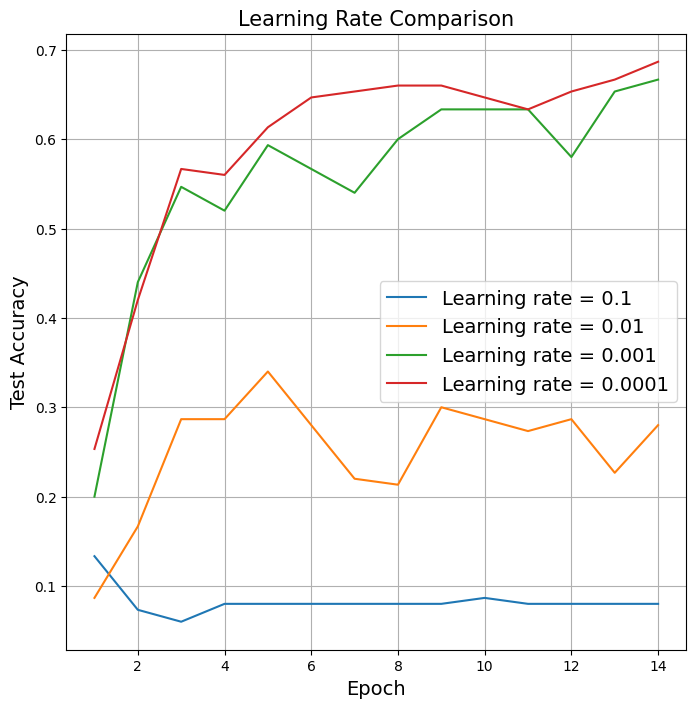

In [ ]:
#plot loss and test accuracy for learning rate test
#plot train, test accuracy for softmax vs square loss
lrmodels = [lrmodel1, lrmodel2, lrmodel3, lrmodel4]
plt.figure(figsize=(8, 8))
for i, lr in enumerate(learning_rates):
  plt.plot(range(1, 15), lrmodels[i].test_accuracy, label=f'Learning rate = {lr}')

plt.title("Learning Rate Comparison", fontsize = 15)
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Test Accuracy', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid(True)
plt.show()

#Batch Size Test

In [ ]:
#batch_size test
batch_sizes = [5, 10, 15, 30]
nets = []
models = []
for batch_size in batch_sizes:
  train_batch = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  test_batch = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
  net2121 = SimpleCNN_BN()
  learning_rate = 0.001
  softmax = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net2121.parameters(), lr=learning_rate)
  model = run(net2121, 15, softmax, optimizer, True , train_batch, test_batch)
  print(f"SimpleCNN training with batch_size = {batch_size} Done")
  models.append(model)

Training...

EPOCH 1 ...
Train Accuracy = 0.487
Test Accuracy = 0.367

EPOCH 2 ...
Train Accuracy = 0.667
Test Accuracy = 0.433

EPOCH 3 ...
Train Accuracy = 0.773
Test Accuracy = 0.513

EPOCH 4 ...
Train Accuracy = 0.913
Test Accuracy = 0.600

EPOCH 5 ...
Train Accuracy = 0.887
Test Accuracy = 0.580

EPOCH 6 ...
Train Accuracy = 0.927
Test Accuracy = 0.547

EPOCH 7 ...
Train Accuracy = 0.973
Test Accuracy = 0.647

EPOCH 8 ...
Train Accuracy = 0.980
Test Accuracy = 0.647

EPOCH 9 ...
Train Accuracy = 0.980
Test Accuracy = 0.673

EPOCH 10 ...
Train Accuracy = 0.993
Test Accuracy = 0.673

EPOCH 11 ...
Train Accuracy = 0.980
Test Accuracy = 0.620

EPOCH 12 ...
Train Accuracy = 0.987
Test Accuracy = 0.680

EPOCH 13 ...
Train Accuracy = 1.000
Test Accuracy = 0.673

EPOCH 14 ...
Train Accuracy = 1.000
Test Accuracy = 0.700

Model saved as SimpleCNN_BN_saved.model
SimpleCNN_2_BN training with batch_size = 5 Done
Training...

EPOCH 1 ...
Train Accuracy = 0.340
Test Accuracy = 0.280

EPOCH 2 ..

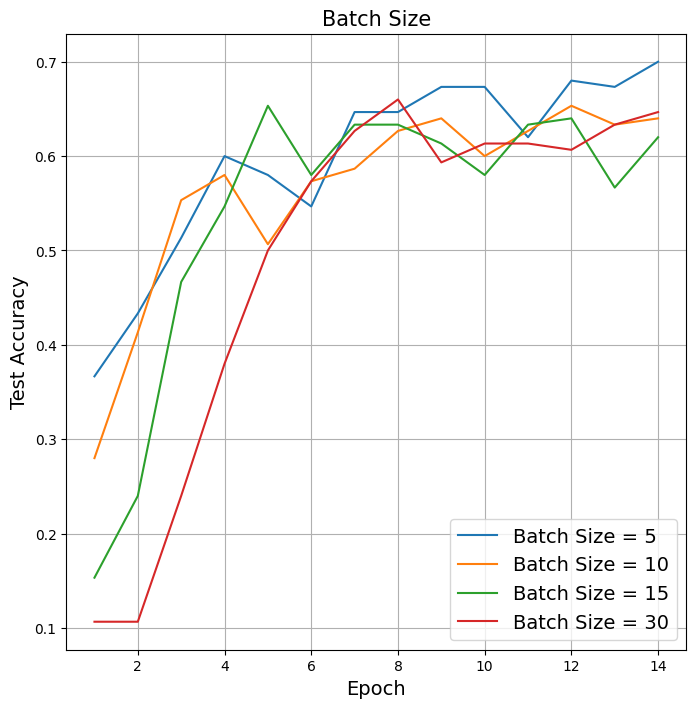

In [ ]:
#plot loss and test accuracy for learning rate test
#plot train, test accuracy for softmax vs square loss
plt.figure(figsize=(8, 8))
for i, lr in enumerate(batch_sizes):
  plt.plot(range(1, 15),models[i].test_accuracy, label=f'Batch Size = {lr}')

plt.title("Batch Size", fontsize = 15)
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Test Accuracy', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid(True)
plt.show()

# Truncated SVD



Extract Features

In [ ]:
class SimpleCNN_SVD(nn.Module):
    def __init__(self, dropout=True, rank=64):
        super(SimpleCNN_SVD, self).__init__()
        self.dropout = dropout

        # Define convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False)

        # Define batch normalization layers
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(256)

        # Define fully connected layers
        self.fc1 = nn.Linear(256 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

        self.svd_rank = rank

        self.use_svd = True

    def apply_svd(self):
        # Apply SVD to fc1
        U, S, Vh = svd(self.fc1.weight.detach())
        S[self.svd_rank:] = 0  # Truncate the singular values
        self.fc1.weight.data = torch.mm(torch.mm(U, torch.diag(S)), Vh)

        self.use_svd = True

    def forward(self, x):
        # Conv -> ReLU -> MaxPool -> BatchNorm
        x = F.relu(self.conv1(x))
        x = self.bn1(F.max_pool2d(x, 2))

        x = F.relu(self.conv2(x))
        x = self.bn2(F.max_pool2d(x, 2))

        x = F.relu(self.conv3(x))
        x = self.bn3(F.max_pool2d(x, 2))

        x = F.relu(self.conv4(x))
        x = self.bn4(F.max_pool2d(x, 2))

        x = F.relu(self.conv5(x))
        x = self.bn5(F.max_pool2d(x, 2))

        x = x.view(x.size(0), -1)  # Flatten the tensor

        # Fully connected layers
        if self.use_svd:
            with torch.no_grad():
                x = F.relu(self.fc1(x))
        else:
            x = F.relu(self.fc1(x))

        if self.dropout:
            x = F.dropout(x, 0.5, training=self.training)
        x = self.fc2(x)

        return x


Train

In [ ]:
#SVD test
ranks = [40, 64, 80, 100]
parameters_count =[]
svdmodels = []
for rank in ranks:
  netsvd = SimpleCNN_SVD(True, rank)
  learning_rate = 0.001
  softmax = nn.CrossEntropyLoss()
  optimizer = optim.Adam(netsvd.parameters(), lr=learning_rate)
  model = run(netsvd, 15, softmax, optimizer, True)
  print(f"SimpleCNN_SVD training with rank = {rank} Done")
  svdmodels.append(model)

Training...

EPOCH 1 ...
Train Accuracy = 0.147
Test Accuracy = 0.087

EPOCH 2 ...
Train Accuracy = 0.240
Test Accuracy = 0.187

EPOCH 3 ...
Train Accuracy = 0.313
Test Accuracy = 0.180

EPOCH 4 ...
Train Accuracy = 0.407
Test Accuracy = 0.180

EPOCH 5 ...
Train Accuracy = 0.467
Test Accuracy = 0.200

EPOCH 6 ...
Train Accuracy = 0.493
Test Accuracy = 0.247

EPOCH 7 ...
Train Accuracy = 0.553
Test Accuracy = 0.240

EPOCH 8 ...
Train Accuracy = 0.560
Test Accuracy = 0.267

EPOCH 9 ...
Train Accuracy = 0.587
Test Accuracy = 0.287

EPOCH 10 ...
Train Accuracy = 0.627
Test Accuracy = 0.307

EPOCH 11 ...
Train Accuracy = 0.627
Test Accuracy = 0.307

EPOCH 12 ...
Train Accuracy = 0.667
Test Accuracy = 0.333

EPOCH 13 ...
Train Accuracy = 0.647
Test Accuracy = 0.353

EPOCH 14 ...
Train Accuracy = 0.667
Test Accuracy = 0.333

Model saved as SimpleCNN_SVD_saved.model
SimpleCNN_SVD training with rank = 40 Done
Training...

EPOCH 1 ...
Train Accuracy = 0.093
Test Accuracy = 0.107

EPOCH 2 ...
Tra

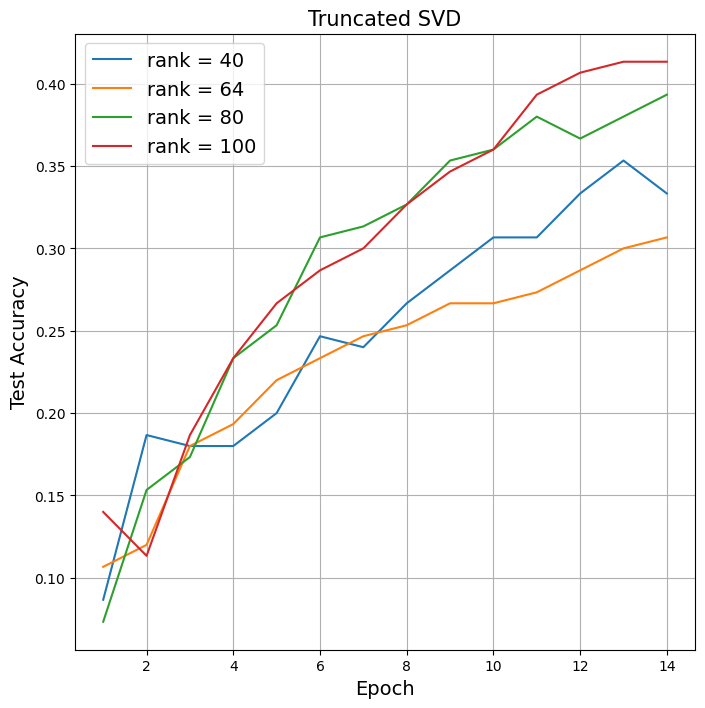

In [ ]:
#accuracy vs rank
plt.figure(figsize=(8, 8))
for i, rank in enumerate(ranks):
  plt.plot(range(1, 15),svdmodels[i].test_accuracy, label=f'rank = {rank}')

plt.title("Truncated SVD", fontsize = 15)
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Test Accuracy', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid(True)
plt.show()

# Final Model

In [ ]:
final_net = SimpleCNN_BN()
#print(net)
learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_net.parameters(), lr=learning_rate)
train_batch = DataLoader(dataset_train, batch_size=5, shuffle=True)
test_batch = DataLoader(dataset_test, batch_size=5, shuffle=False)
final_model = run(final_net, 100, criterion, optimizer, True , train_batch, test_batch)


Training...

EPOCH 1 ...
Train Accuracy = 0.460
Test Accuracy = 0.360

EPOCH 2 ...
Train Accuracy = 0.920
Test Accuracy = 0.627

EPOCH 3 ...
Train Accuracy = 0.987
Test Accuracy = 0.607

EPOCH 4 ...
Train Accuracy = 1.000
Test Accuracy = 0.627

EPOCH 5 ...
Train Accuracy = 1.000
Test Accuracy = 0.633

EPOCH 6 ...
Train Accuracy = 1.000
Test Accuracy = 0.640

EPOCH 7 ...
Train Accuracy = 1.000
Test Accuracy = 0.627

EPOCH 8 ...
Train Accuracy = 1.000
Test Accuracy = 0.660

EPOCH 9 ...
Train Accuracy = 1.000
Test Accuracy = 0.647

EPOCH 10 ...
Train Accuracy = 1.000
Test Accuracy = 0.673

EPOCH 11 ...
Train Accuracy = 1.000
Test Accuracy = 0.667

EPOCH 12 ...
Train Accuracy = 1.000
Test Accuracy = 0.680

EPOCH 13 ...
Train Accuracy = 1.000
Test Accuracy = 0.653

EPOCH 14 ...
Train Accuracy = 1.000
Test Accuracy = 0.667

EPOCH 15 ...
Train Accuracy = 1.000
Test Accuracy = 0.667

EPOCH 16 ...
Train Accuracy = 1.000
Test Accuracy = 0.667

EPOCH 17 ...
Train Accuracy = 1.000
Test Accuracy = 

# Finetuning Exisiting Model: Resnet50

In [ ]:
#resnet 50
resnet50 = models.resnet50(pretrained=True)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 10)
optimizer = torch.optim.SGD(resnet50.fc.parameters(), lr=0.0001)
resnet50_model = run(resnet50, 100, criterion, optimizer, False , train_batch, test_batch)


Training...

EPOCH 1 ...
Train Accuracy = 0.093
Test Accuracy = 0.087

EPOCH 2 ...
Train Accuracy = 0.087
Test Accuracy = 0.080

EPOCH 3 ...
Train Accuracy = 0.113
Test Accuracy = 0.093

EPOCH 4 ...
Train Accuracy = 0.133
Test Accuracy = 0.100

EPOCH 5 ...
Train Accuracy = 0.153
Test Accuracy = 0.113

EPOCH 6 ...
Train Accuracy = 0.167
Test Accuracy = 0.107

EPOCH 7 ...
Train Accuracy = 0.193
Test Accuracy = 0.120

EPOCH 8 ...
Train Accuracy = 0.200
Test Accuracy = 0.120

EPOCH 9 ...
Train Accuracy = 0.240
Test Accuracy = 0.140

EPOCH 10 ...
Train Accuracy = 0.273
Test Accuracy = 0.153

EPOCH 11 ...
Train Accuracy = 0.280
Test Accuracy = 0.160

EPOCH 12 ...
Train Accuracy = 0.327
Test Accuracy = 0.193

EPOCH 13 ...
Train Accuracy = 0.353
Test Accuracy = 0.227

EPOCH 14 ...
Train Accuracy = 0.380
Test Accuracy = 0.260

EPOCH 15 ...
Train Accuracy = 0.400
Test Accuracy = 0.247

EPOCH 16 ...
Train Accuracy = 0.393
Test Accuracy = 0.253

EPOCH 17 ...
Train Accuracy = 0.413
Test Accuracy = 

#Comparing Final Model and the Finetuned Resnet50

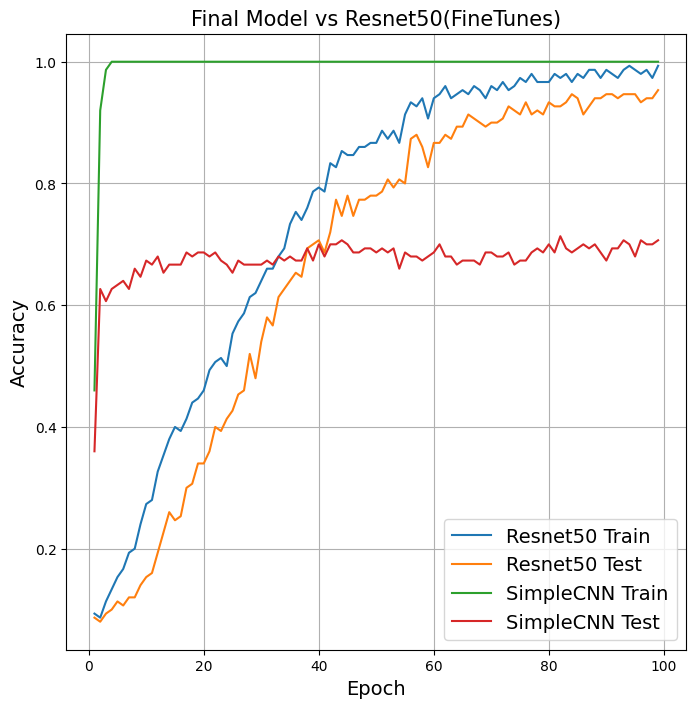

In [ ]:
#accuracy vs rank
plt.figure(figsize=(8, 8))
plt.plot(range(1, 100),resnet50_model.train_accuracy, label= "Resnet50 Train")
plt.plot(range(1, 100),resnet50_model.test_accuracy, label= "Resnet50 Test")
plt.plot(range(1, 100),final_model.train_accuracy, label= "SimpleCNN Train")
plt.plot(range(1, 100),final_model.test_accuracy, label= "SimpleCNN Test")

plt.title("Final Model vs Resnet50(FineTunes)", fontsize = 15)
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid(True)
plt.show()